<a href="https://colab.research.google.com/github/akpanitorobong/7120CEM-Natural_Language_Processing/blob/main/7120_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.) Project preparation**

**Neccessary Imports**

In [3]:
# Install required resources
!pip install --upgrade gensim nltk tensorflow keras imblearn contractions emoji

# Import required libraries
import os
import numpy as np  # Numerical operations
import pandas as pd  # Data handling
import codecs #handle punctuations
import nltk  # Natural Language Toolkit (NLTK)
import contractions #handle word contractions
import emoji #handle emojis
from nltk.corpus import stopwords  # Stopword removal
from nltk.tokenize import word_tokenize  # Tokenization
from nltk.stem import WordNetLemmatizer  # Lemmatization
import re  # Regular expressions for text cleaning
import gensim.downloader as api  # Pre-trained embeddings
from collections import Counter  # Word frequency analysis
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns  # Statistical visualization
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))
from bs4 import BeautifulSoup  # HTML tag removal
from imblearn.over_sampling import RandomOverSampler  # Class balancing
from imblearn.over_sampling import SMOTE  # Class balancing
from tensorflow.keras.preprocessing.text import Tokenizer  # Text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Padding sequences
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # Import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Feature extraction
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score # Model evaluation
from sklearn.linear_model import LogisticRegression  # ML model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # ML models
from sklearn.svm import SVC  # Support Vector Machine
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes classifier
import gc


# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.0 MB/s eta 0:00:00
GPU Available: []


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Dataset access**

In [4]:
#clone github with access to the dataset
!git clone https://github.com/akpanitorobong/7120CEM-Natural_Language_Processing.git

Cloning into '7120CEM-Natural_Language_Processing'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 19), reused 34 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 3.98 MiB | 10.15 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [5]:
valid_extensions = {".txt", ".csv"}#extensions for dataset files

#navigate to data
train_path = "/content/7120CEM-Natural_Language_Processing/dataset/train"
train_list =  os.listdir(train_path)
train_list = [f for f in os.listdir(train_path) if os.path.splitext(f)[1] in valid_extensions]

test_path = "/content/7120CEM-Natural_Language_Processing/dataset/test"
test_list = os.listdir(test_path)
test_list = [f for f in os.listdir(test_path) if os.path.splitext(f)[1] in valid_extensions]

#create folder to store cleaned datasets for training and testing
if not os.path.exists("preprocessed_datasets"):
    os.makedirs("preprocessed_datasets")

files_2013 = []
files_2016 = []
for file in train_list:
    file_path = os.path.join(train_path, file)
    if "2013" in file:
        files_2013.append(file)
    elif "2016" in file:
        files_2016.append(file)


#check file names
print("2013 Training List",files_2013)
print("2016 Training List",files_2016)
print("Testing List",test_list)

2013 Training List ['twitter-2013dev-A.txt', 'twitter-2013test-A.txt', 'twitter-2013train-A.txt']
2016 Training List ['twitter-2016dev-A.txt', 'twitter-2016train-A.txt', 'twitter-2016test-A.txt']
Testing List ['SemEval2017-task4-test.subtask-A.english.txt']


# **2.) Preprocessing**

**Inspect Dataset**

In [6]:
#file to be inspected
sample_file = train_list[0]
sample_file_dir = train_path+"/"+sample_file

#read file
with open(sample_file_dir, "r", encoding="ascii") as f:
    lines = f.readlines()

# Print first 5 lines to understand format
print("First 5 lines of %s: " %sample_file, lines[:5])

First 5 lines of twitter-2016dev-A.txt:  ['638060586258038784\tneutral\t05 Beat it - Michael Jackson - Thriller (25th Anniversary Edition) [HD] http://t.co/A4K2B86PBv\n', '638061181823922176\tpositive\tJay Z joins Instagram with nostalgic tribute to Michael Jackson: Jay Z apparently joined Instagram on Saturday and.. http://t.co/Qj9I4eCvXy\n', '638083821364244480\tneutral\tMichael Jackson: Bad 25th Anniversary Edition (Picture Vinyl): This unique picture disc vinyl includes the original 1 http://t.co/fKXhToAAuW\n', '638091450132078593\tpositive\tI liked a @YouTube video http://t.co/AaR3pjp2PI One Direction singing "Man in the Mirror" by Michael Jackson in Atlanta, GA [June 26,\n', "638125563790557184\tpositive\t18th anniv of Princess Diana's death. I still want to believe she is living on a private island away from the public. With Michael Jackson.\n"]


**Clean text function**

In [7]:
# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
chat_words = {
    "AFAIK": "As Far As I Know", "AFK": "Away From Keyboard", "ASAP": "As Soon As Possible", "ATK": "At The Keyboard",
    "ATM": "At The Moment", "A3": "Anytime, Anywhere, Anyplace", "BAK": "Back At Keyboard", "BBL": "Be Back Later",
    "BBS": "Be Back Soon", "BFN": "Bye For Now", "B4N": "Bye For Now", "BRB": "Be Right Back", "BRT": "Be Right There",
    "BTW": "By The Way", "B4": "Before", "CU": "See You", "CUL8R": "See You Later", "CYA": "See You",
    "FAQ": "Frequently Asked Questions", "FC": "Fingers Crossed", "FWIW": "For What It's Worth", "FYI": "For Your Information",
    "GAL": "Get A Life", "GG": "Good Game", "GN": "Good Night", "GMTA": "Great Minds Think Alike", "GR8": "Great!",
    "G9": "Genius", "IC": "I See", "ICQ": "I Seek you", "ILU": "I Love You", "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion", "IOW": "In Other Words", "IRL": "In Real Life", "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship", "LMAO": "Laugh My A.. Off", "LOL": "Laughing Out Loud", "LTNS": "Long Time No See",
    "L8R": "Later", "MTE": "My Thoughts Exactly", "M8": "Mate", "NRN": "No Reply Necessary", "OIC": "Oh I See",
    "PITA": "Pain In The A..", "PRT": "Party", "PRW": "Parents Are Watching", "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing", "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off", "SK8": "Skate", "STATS": "Your sex and age", "ASL": "Age, Sex, Location",
    "THX": "Thank You", "TTFN": "Ta-Ta For Now!", "TTYL": "Talk To You Later", "U": "You", "U2": "You Too",
    "U4E": "Yours For Ever", "WB": "Welcome Back", "WTF": "What The F...", "WTG": "Way To Go!", "WUF": "Where Are You From?",
    "W8": "Wait...", "7K": "Sick:-D Laugher", "TFW": "That feeling when", "MFW": "My face when", "MRW": "My reaction when",
    "IFYP": "I feel your pain", "TNTL": "Trying not to laugh", "JK": "Just kidding", "IDC": "I don’t care", "ILY": "I love you",
    "IMU": "I miss you", "ADIH": "Another day in hell", "ZZZ": "Sleeping, bored, tired", "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes", "BAE": "Before anyone else", "FIMH": "Forever in my heart", "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter", "BFF": "Best friends forever", "CSL": "Can’t stop laughing"
}

# Dictionary of Unicode escape sequences and their replacements
unicode_replacements = {
    "\\u002c": ",",
    "\\u002e": ".",
    "\\u003a": ":",
    "\\u003b": ";",
    "\\u0021": "!",
    "\\u003f": "?",
    "\\u0027": "'",
    "\\u0022": '"',
    "\\u002d": "-",
    "\\u2019": "’",
    "\\u201c": "“",
    "\\u201d": "”",
    "\\u2014": "—",
    "\\u2026": "…"
}

# Function to clean text
def clean_text(text):
    for unicode_code, char in unicode_replacements.items():
        text = text.replace(unicode_code, char)

    text = text.lower()  # Convert to lowercase
    text = contractions.fix(text)  # Expand contractions first
    text = emoji.demojize(text)  # Convert emojis to text
    text = re.sub(r"(https?://\S+|www\.\S+)", "", text)  # Remove URLs
    text = re.sub(r"[“”’]", "'", text)  # Normalize fancy quotes
    text = re.sub(r"[^\w\s']", "", text)  # Remove unwanted punctuation but keep apostrophes
    text = re.sub(r'([aeiou])\1{2,}', r'\1\1', text)  # Reduce excessive vowels
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = text.strip()  # Remove leading/trailing spaces
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space

    words = text.split()
    words = [chat_words.get(word, word) for word in words]  # Expand chat words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization & Stopword removal

    return " ".join(words)

print ("clean_text function defined successfully")

clean_text function defined successfully


**Clean dataset, combine and re-store**

In [8]:
def load_and_preprocess_data(files, folder):
    """
    Loads and preprocesses text data from multiple files.

    - Attempts to read each file using ASCII encoding first.
    - Falls back to UTF-8 encoding if ASCII fails (handles mixed encoding files).
    - Splits each line using tab (`\t`) to extract labels and text.
    - Applies a text-cleaning function to preprocess text.

    Args:
        files (list): List of filenames to process.
        folder (str): Path to the folder containing the files.

    Returns:
        pd.DataFrame: DataFrame with 'text' and 'label' columns.
    """

    all_texts, all_labels = [], []  # Lists to store extracted text and labels

    for file in files:
        file_path = os.path.join(folder, file)  # Full file path

        # Attempt to read the file in ASCII first
        try:
            with open(file_path, "r", encoding="ascii") as f:
                lines = f.readlines()  # Read all lines at once
        except UnicodeDecodeError:
            # If ASCII fails, retry with UTF-8
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()

        # Process each line in the file
        for line in lines:
            parts = line.strip().split("\t")  # Split on tab characters

            # Ensure there are at least 3 parts (index 1 = label, index 2+ = text)
            if len(parts) >= 3:
                label = parts[1]  # Extract label
                # If there are multiple text fields, join them back with tabs
                text = '\t'.join(parts[2:]) if len(parts) > 3 else parts[2]

                text = clean_text(text)  # Apply text cleaning function

                all_texts.append(text)
                all_labels.append(label)

    # Convert lists to a Pandas DataFrame
    return pd.DataFrame({"text": all_texts, "label": all_labels})

print ("load_and_preprocess_data function defined successfully")

load_and_preprocess_data function defined successfully


**Load cleaned training data**

In [9]:
# Load cleaned training data
df_2013 = load_and_preprocess_data(files_2013, train_path)
df_2016 = load_and_preprocess_data(files_2016, train_path)
df_2013.to_csv("preprocessed_datasets/2013_data.csv", index=False)
df_2016.to_csv("preprocessed_datasets/2016_data.csv", index=False)
print(df_2013.shape)
print("Sample Processed Text(2013 data):", "\n%s" %df_2013["text"].head())
print(df_2016.shape)
print("Sample Processed Text(2016 data):", "\n%s" %df_2016["text"].head())

(14885, 2)
Sample Processed Text(2013 data): 
0    match getin plus tomorrow busy day awareness d...
1    area new england could see first flake season ...
2    francesco_con40 2nd worst qb definitely tony r...
3    thailand washington u president barack obama v...
4    hear tony romo dressed halloween giant quaterb...
Name: text, dtype: object
(28631, 2)
Sample Processed Text(2016 data): 
0    05 beat michael jackson thriller 25th annivers...
1    jay z join instagram nostalgic tribute michael...
2    michael jackson bad 25th anniversary edition p...
3    liked youtube video one direction singing man ...
4    18th anniv princess diana's death still want b...
Name: text, dtype: object


**Load cleaned testing data**

In [10]:
#load cleaned testing data
test_df = load_and_preprocess_data(test_list, test_path)
test_df.to_csv("preprocessed_datasets/cleaned_test_data.csv", index=False)
print(test_df.shape)
print("Sample Processed Text:", "\n%s" %test_df["text"].head())

(12284, 2)
Sample Processed Text: 
0    arianagrande ari ariana grande 80 full singer ...
1    ariana grande kiis fm truly cd listening party...
2    ariana grande white house easter egg roll wash...
3    cd music ariana grande sweet like candy 34 oz ...
4    side side face_blowing_a_kiss arianagrande sid...
Name: text, dtype: object


**Label Encoding**

In [11]:
# Encode labels: {"neutral": 0, "positive": 1, "negative": 2}
label_mapping = {"neutral": 0, "positive": 1, "negative": 2}
df_2013["label_num"] = df_2013["label"].map(label_mapping)
df_2016["label_num"] = df_2016["label"].map(label_mapping)
test_df["label_num"] = test_df["label"].map(label_mapping)
print ("labels successfully encoded")

labels successfully encoded


**Check for duplicates**

In [12]:
# Count duplicate rows
print(f"Number of duplicate rows in 2013 data: {df_2013.duplicated().sum()}")
print(f"Number of rows before removal: {len(df_2013)}\n")

print(f"Number of duplicate rows in 2016 data: {df_2016.duplicated().sum()}")
print(f"Number of rows before removal: {len(df_2016)}\n")

print(f"Number of duplicate rows in test data: {test_df.duplicated().sum()}")
print(f"Number of rows before removal: {len(test_df)}")

Number of duplicate rows in 2013 data: 112
Number of rows before removal: 14885

Number of duplicate rows in 2016 data: 125
Number of rows before removal: 28631

Number of duplicate rows in test data: 8
Number of rows before removal: 12284


**Remove duplicates**

In [13]:
# Remove duplicate rows and reset index
df_2013_cleaned = df_2013.drop_duplicates().reset_index(drop=True)
df_2016_cleaned = df_2016.drop_duplicates().reset_index(drop=True)
test_df_cleaned = test_df.drop_duplicates().reset_index(drop=True)

# Verify removal
print(f"Number of duplicate rows in 2013 data: {df_2013_cleaned.duplicated().sum()}")
print(f"Number of rows after removal: {len(df_2013_cleaned)}\n")

print(f"Number of duplicate rows in 2016 data: {df_2016_cleaned.duplicated().sum()}")
print(f"Number of rows after removal: {len(df_2016_cleaned)}\n")

print(f"Number of duplicate rows in test data: {test_df_cleaned.duplicated().sum()}")
print(f"Number of rows after removal: {len(test_df_cleaned)}")

Number of duplicate rows in 2013 data: 0
Number of rows after removal: 14773

Number of duplicate rows in 2016 data: 0
Number of rows after removal: 28506

Number of duplicate rows in test data: 0
Number of rows after removal: 12276


**Check for missing values**

In [14]:
# Check for missing values
print("Missing values in 2013 data:")
print(df_2013_cleaned.isnull().sum())

print("\nMissing values in 2016 data:")
print(df_2016_cleaned.isnull().sum())

print("\nMissing values in test data:")
print(test_df_cleaned.isnull().sum())

Missing values in 2013 data:
text         0
label        0
label_num    0
dtype: int64

Missing values in 2016 data:
text         0
label        0
label_num    0
dtype: int64

Missing values in test data:
text         0
label        0
label_num    0
dtype: int64


# **3.) Data Visualization**

**2013 Data distribution**

In [15]:
# Get sentiment class counts
sentiment_counts_2013 = df_2013_cleaned['label'].value_counts()

# Convert to a DataFrame for better visualization
sentiment_df = pd.DataFrame({'Sentiment': sentiment_counts_2013.index, 'Count': sentiment_counts_2013.values})

# Display the DataFrame
print("Sentiment distribution in 2013 data\n",sentiment_df)
sentiment_df.to_csv("sentiment_counts_2013.csv", index=False)

Sentiment distribution in 2013 data
   Sentiment  Count
0   neutral   6772
1  positive   5658
2  negative   2343


**2016 Data distribution**

In [16]:
sentiment_counts_2016 = df_2016_cleaned['label'].value_counts()
sentiment_df = pd.DataFrame({'Sentiment': sentiment_counts_2016.index, 'Count': sentiment_counts_2016.values})
print("Sentiment distribution in 2016 data\n",sentiment_df)
sentiment_df.to_csv("sentiment_counts_2016.csv", index=False)

Sentiment distribution in 2016 data
   Sentiment  Count
0   neutral  13088
1  positive  10958
2  negative   4460


**2017 Data distribution**

In [17]:
sentiment_counts_test = test_df_cleaned['label'].value_counts()
sentiment_df = pd.DataFrame({'Sentiment': sentiment_counts_test.index, 'Count': sentiment_counts_test.values})
print("Sentiment distribution in test data\n",sentiment_df)
sentiment_df.to_csv("sentiment_counts_test.csv", index=False)

Sentiment distribution in test data
   Sentiment  Count
0   neutral   5931
1  negative   3970
2  positive   2375


**2013 data class distribution plot**

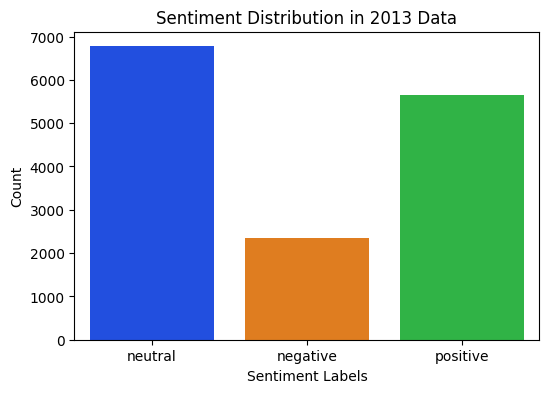

In [18]:
# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df_2013_cleaned['label'], palette="bright", hue=df_2013_cleaned['label'])
plt.title("Sentiment Distribution in 2013 Data")
plt.xlabel("Sentiment Labels")
plt.ylabel("Count")
plt.show()

**2016 data class distribution plot**

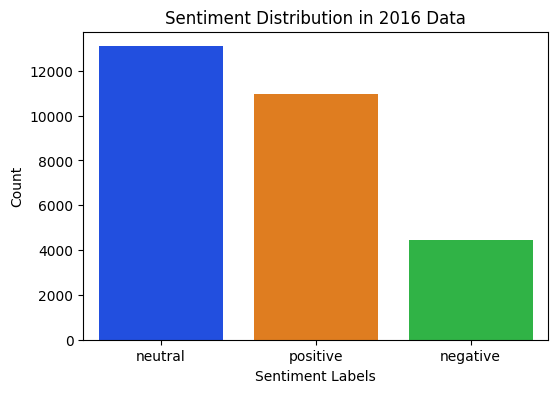

In [19]:
# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df_2016_cleaned['label'], palette="bright", hue=df_2016_cleaned['label'])
plt.title("Sentiment Distribution in 2016 Data")
plt.xlabel("Sentiment Labels")
plt.ylabel("Count")
plt.show()

**2013 data tweet length distribution**

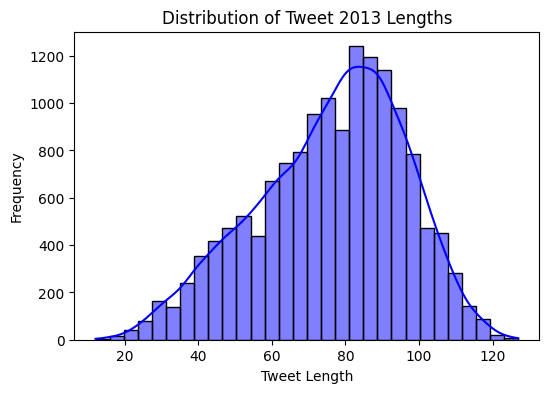

In [20]:
# Analyze tweet length distribution
df_2013_cleaned['text_length'] = df_2013_cleaned['text'].apply(len)

# Plot histogram of tweet lengths
plt.figure(figsize=(6,4))
sns.histplot(df_2013_cleaned['text_length'], bins=30, kde=True, color='blue')
plt.title("Distribution of Tweet 2013 Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

**2016 data tweet length distribution**

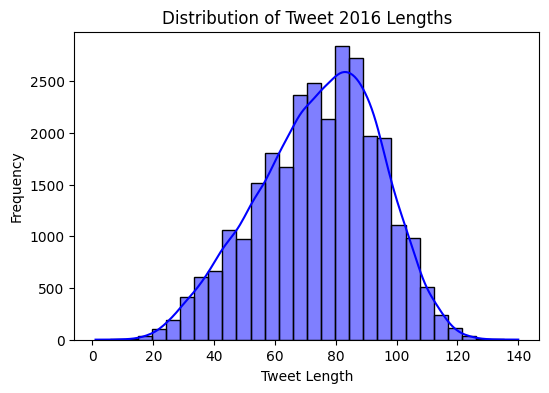

In [21]:
# Analyze tweet length distribution
df_2016_cleaned['text_length'] = df_2016_cleaned['text'].apply(len)

# Plot histogram of tweet lengths
plt.figure(figsize=(6,4))
sns.histplot(df_2016_cleaned['text_length'], bins=30, kde=True, color='blue')
plt.title("Distribution of Tweet 2016 Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

# **4.) Feature Representation**

In [22]:
# Assign training datasets
train_df_2013 = df_2013_cleaned
train_df_2016 = df_2016_cleaned

# Dictionary to store model performances
results = {}

# Define feature extraction methods: BoW & TF-IDF
vectorizers = {
    "BoW": CountVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF": TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
}

# Transform datasets using each feature representation
feature_matrices = {}

for feature_type, vectorizer in vectorizers.items():
    print(f"\nApplying {feature_type} feature representation...")

    # Convert text data into numerical feature representations
    feature_matrices[feature_type] = {
        "X_train_2013": vectorizer.fit_transform(train_df_2013["text"]),
        "X_train_2016": vectorizer.fit_transform(train_df_2016["text"]),
        "X_test": vectorizer.transform(test_df["text"]),
        "y_train_2013": train_df_2013["label_num"],
        "y_train_2016": train_df_2016["label_num"],
        "y_test": test_df["label_num"]
    }


Applying BoW feature representation...

Applying TF-IDF feature representation...


# **5.) Dataset Balancing**

In [23]:
# Apply Random Oversampling to balance training data
balanced_datasets = {}

for feature_type, data in feature_matrices.items():
    print(f"\nApplying Random Oversampling for {feature_type} representation...")

    ros = RandomOverSampler(random_state=42)

    # Balance training data
    X_train_2013_bal, y_train_2013_bal = ros.fit_resample(data["X_train_2013"], data["y_train_2013"])
    X_train_2016_bal, y_train_2016_bal = ros.fit_resample(data["X_train_2016"], data["y_train_2016"])

    balanced_datasets[feature_type] = {
        "X_train_2013_bal": X_train_2013_bal, "y_train_2013_bal": y_train_2013_bal,
        "X_train_2016_bal": X_train_2016_bal, "y_train_2016_bal": y_train_2016_bal,
        "X_test": data["X_test"], "y_test": data["y_test"]
    }


Applying Random Oversampling for BoW representation...

Applying Random Oversampling for TF-IDF representation...


**Post Balancing Plot**

Visualizing balanced dataset for BoW representation...



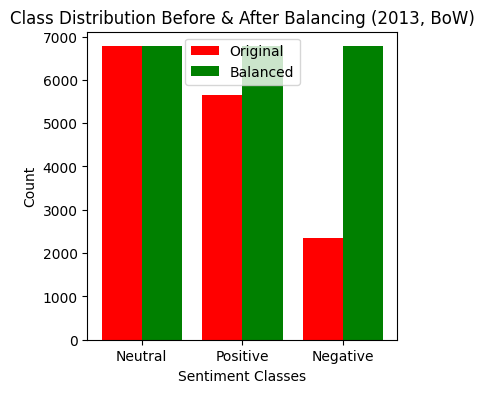

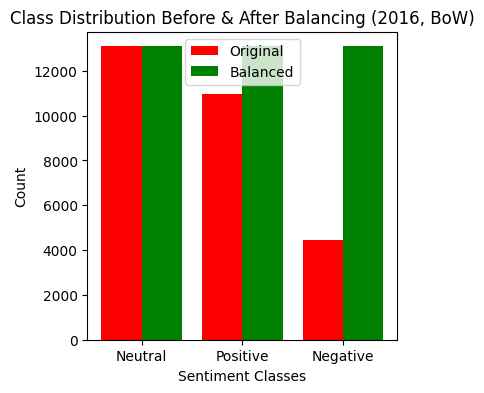

Visualizing balanced dataset for TF-IDF representation...



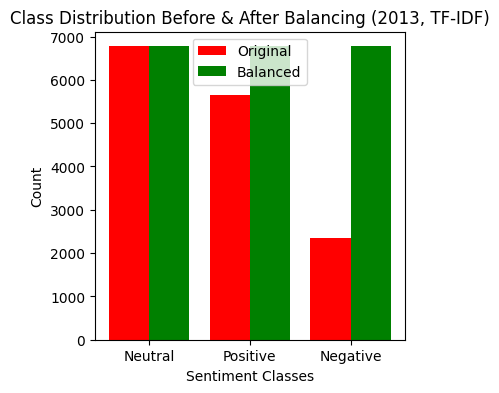

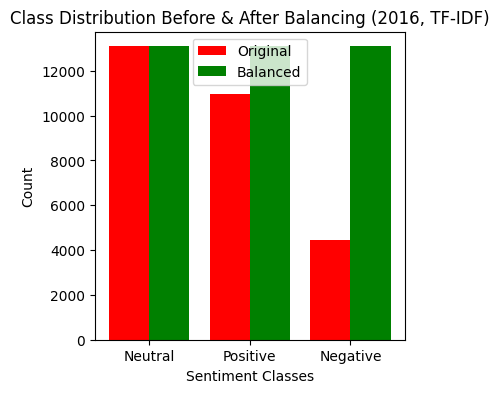

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Reverse the label mapping (numeric -> sentiment label)
label_mapping_reversed = {0: "Neutral", 1: "Positive", 2: "Negative"}

# Function to plot class distributions before and after balancing
def plot_class_distribution(original_y, balanced_y, title):
    """
    Plots the distribution of sentiment classes before and after balancing.

    Parameters:
    - original_y: Original sentiment labels before balancing
    - balanced_y: Sentiment labels after balancing
    - title: Title of the plot
    """

    plt.figure(figsize=(4, 4))  # Set figure size

    # Get unique sentiment classes and their counts
    unique_classes, counts_original = np.unique(original_y, return_counts=True)
    _, counts_balanced = np.unique(balanced_y, return_counts=True)

    # Convert numerical labels back to sentiment labels
    class_labels = [label_mapping_reversed[c] for c in unique_classes]

    # Set bar width for side-by-side comparison
    bar_width = 0.4
    x = np.arange(len(unique_classes))

    # Plot original distribution (before balancing)
    plt.bar(x - bar_width / 2, counts_original, width=bar_width, label="Original", color="red")

    # Plot balanced distribution (after balancing)
    plt.bar(x + bar_width / 2, counts_balanced, width=bar_width, label="Balanced", color="green")

    # Set x-axis labels to sentiment names
    plt.xticks(x, class_labels)
    plt.xlabel("Sentiment Classes")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()

# Visualizing class distributions before and after balancing
for feature_type, data in balanced_datasets.items():
    print(f"Visualizing balanced dataset for {feature_type} representation...\n")

    # 2013 Data
    plot_class_distribution(
        original_y=feature_matrices[feature_type]["y_train_2013"],
        balanced_y=data["y_train_2013_bal"],
        title=f"Class Distribution Before & After Balancing (2013, {feature_type})"
    )

    # 2016 Data
    plot_class_distribution(
        original_y=feature_matrices[feature_type]["y_train_2016"],
        balanced_y=data["y_train_2016_bal"],
        title=f"Class Distribution Before & After Balancing (2016, {feature_type})"
    )

# **6.) ML Models**

In [25]:
# Define ML models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear"),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naïve Bayes": MultinomialNB()
}

# Store all results in a list
results_list = []

# Train and evaluate models
for feature_type, data in balanced_datasets.items():
    print(f"\nTraining models using {feature_type} representation...")

    for model_name, model in models.items():
        print(f"\nTraining {model_name} on 2013 data...")
        model.fit(data["X_train_2013_bal"], data["y_train_2013_bal"])
        y_pred_2013 = model.predict(data["X_test"])
        acc_2013 = accuracy_score(data["y_test"], y_pred_2013)
        f1_2013 = classification_report(data["y_test"], y_pred_2013, output_dict=True)["macro avg"]["f1-score"]

        print(f"Training {model_name} on 2016 data...")
        model.fit(data["X_train_2016_bal"], data["y_train_2016_bal"])
        y_pred_2016 = model.predict(data["X_test"])
        acc_2016 = accuracy_score(data["y_test"], y_pred_2016)
        f1_2016 = classification_report(data["y_test"], y_pred_2016, output_dict=True)["macro avg"]["f1-score"]

        # Append results as a dictionary to the list
        results_list.append({
            "Feature Representation": feature_type,
            "Model": model_name,
            "2013 Accuracy": acc_2013,
            "2013 F1 Score": f1_2013,
            "2016 Accuracy": acc_2016,
            "2016 F1 Score": f1_2016,
            "Perf Drop": f1_2016 - f1_2013  # Measures performance degradation over time
        })

# Convert list of results into DataFrame
results_df = pd.DataFrame(results_list)

# Convert accuracy and F1-score values to percentages
results_df[["2013 Accuracy", "2013 F1 Score", "2016 Accuracy", "2016 F1 Score", "Perf Drop"]] *= 100

# Save and display results
results_df.to_csv("model_performance.csv", index=False)
print(results_df)
print("\nModel performance results saved in 'model_performance.csv'.")


Training models using BoW representation...

Training Random Forest on 2013 data...
Training Random Forest on 2016 data...

Training Gradient Boosting on 2013 data...
Training Gradient Boosting on 2016 data...

Training SVM on 2013 data...
Training SVM on 2016 data...

Training Logistic Regression on 2013 data...
Training Logistic Regression on 2016 data...

Training Naïve Bayes on 2013 data...
Training Naïve Bayes on 2016 data...

Training models using TF-IDF representation...

Training Random Forest on 2013 data...
Training Random Forest on 2016 data...

Training Gradient Boosting on 2013 data...
Training Gradient Boosting on 2016 data...

Training SVM on 2013 data...
Training SVM on 2016 data...

Training Logistic Regression on 2013 data...
Training Logistic Regression on 2016 data...

Training Naïve Bayes on 2013 data...
Training Naïve Bayes on 2016 data...
  Feature Representation                Model  2013 Accuracy  2013 F1 Score  \
0                    BoW        Random Forest 

# **7.) Post Model Visuals**

**Feature Representation Impact (Bar Chart)**

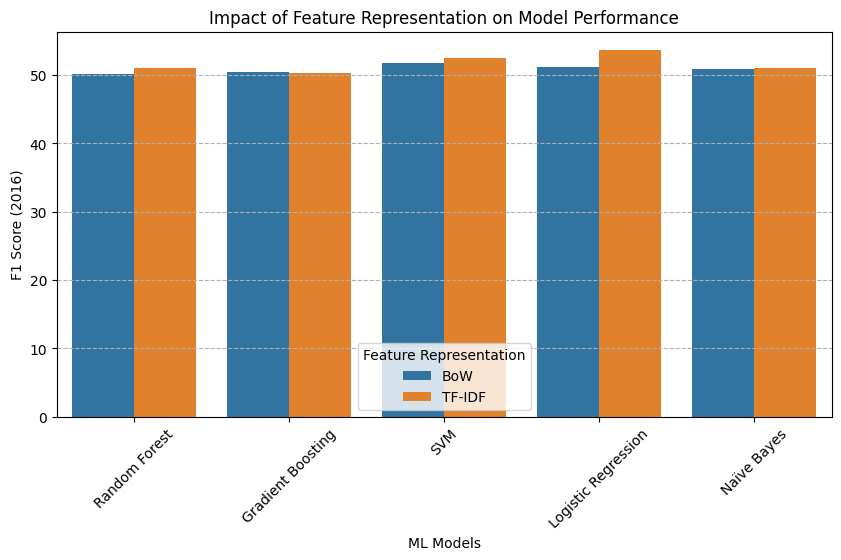

In [28]:
# Create bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df["Model"], y=results_df["2016 F1 Score"], hue=results_df["Feature Representation"])

plt.title("Impact of Feature Representation on Model Performance")
plt.xlabel("ML Models")
plt.ylabel("F1 Score (2016)")
plt.xticks(rotation=45)
plt.legend(title="Feature Representation")
plt.grid(axis='y', linestyle='--')
plt.show()

**Performance Drop Rate by Model (Heatmap)**

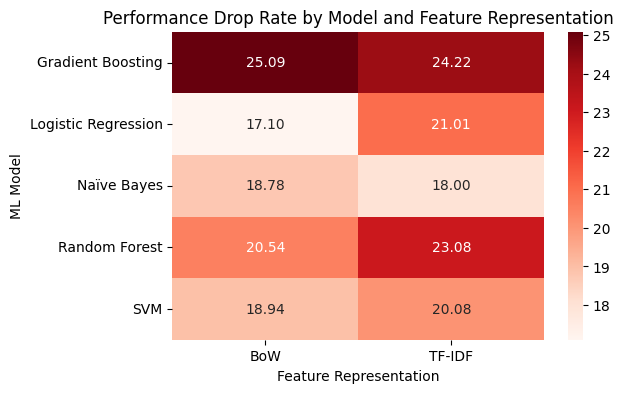

In [37]:
# Compute performance drop
results_df["Perf Drop"] = results_df["2016 F1 Score"] - results_df["2013 F1 Score"]

# Reshape DataFrame for heatmap
drop_rates = results_df.pivot(index="Model", columns="Feature Representation", values="Perf Drop")

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(drop_rates, annot=True, cmap="Reds", fmt=".2f")

plt.title("Performance Drop Rate by Model and Feature Representation")
plt.xlabel("Feature Representation")
plt.ylabel("ML Model")
plt.show()